## CS6650 Homework 2 (Holi 2023 Semester)

---
Name: `Your Name`

Roll No: `EE20B086`

Email: `ee20b086@smail.iitm.ac.in`

---

### Preliminary Analysis of PPG Sensor Signals
Refer to the PPG sensor logs shared in the class lecture wiki. Your task is to perform some preliminary analysis on the same dataset. It consists of three columns, a UNIX epoch timestamp in milliseconds, photodiode responses (digitized) for the IR led and the Red led, respectively. For the rest of the document, we will refer to these digital signals as IR and RED. 

Create a directory, `<Your_Roll>_CS6650H23`. Place this notebook and the dataset file in that directory. Now you will perform the following tasks:

1. [Visualize the data (5 points)](#task1)
2. [Peak detection (15 points)](#task2)
3. [Frequency domain analysis (32 points)](#task3)
4. [Spectrograms (20 points)](#task4)
5. [Quantization of sensor data (28 points)](#task5)

Please keep in mind,

- Clean and well-documented code is expected. Your code should be organized in a clear and readable manner, with each task separated into its own section of the notebook.

- There will be no separate PDF report required this time. Instead, provide a detailed but to-the-point discussion in the observation section for each task. The observation section (in Markdown, Refer to [Markdown-Cheatsheet](https://github.com/lifeparticle/Markdown-Cheatsheet)) includes a clear and concise description of the task, the approach used to solve it, assumptions, and inferences.

- Any extraneous information that does not directly address the question should be removed before submission. This will help to ensure that the answer is clear and easy to follow.

Failure to follow these practices will result in a penalty.

**Deadline: $2^{nd}$, April, 2023**

#### Submission Instructions
- Compress the top-level directory (ZIP format) containing this notebook with your code and the data used for the assignment. (do not remove the outputs from the notebook cells)

- **You MUST refrain from consulting your homework code with others**. Any plagiarism found in your code (or somebody who is referring to your code) will result in zero credits in this assignment.

- Submissions after the deadline will not be entertained.

### Task 1: Visualize the data [5 points] <a id='task1'></a>
Read the dataset into memory.
1. Plot the IR and RED signals in the time domain - approx length of samples ~32.14 seconds.
2. What is the sample rate at which the data has been collected? Is it uniform? If not, what is the standard deviation?

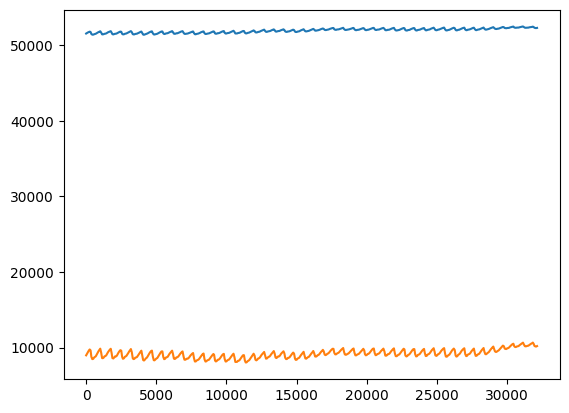

16.068238803051823
1.32744532312083


In [3]:
import matplotlib.pyplot as plt
import cmath
import numpy as np
import csv
  
test_list = [6, 7, 3, 9, 10, 15]
time, IR, RED = [], [] ,[]
x = 0
with open('sample_ppg_log_ayon.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        if(x==0) :
            time_0 = int(row[0][2:15])
            x+=1
        time.append(int(row[0][2:15])-time_0)
        IR.append(int(row[0][26:31]))
        if(row[0][42]==' ') :
            RED.append(int(row[0][43:48]))
        elif(row[0][42]!=' ') :
            RED.append(int(row[0][42:48]))

plt.plot(time, IR)
plt.plot(time, RED)
plt.show()

sample_rate_arr = []
for i in range(0, len(time)-1) :
    sample_time = time[i+1]-time[i]
    sample_rate = 1000/sample_time
    sample_rate_arr.append(sample_rate)

mean = sum(sample_rate_arr) / len(sample_rate_arr)
variance = sum((x - mean) ** 2 for x in sample_rate_arr) / len(sample_rate_arr)
std_dev = variance ** 0.5

print("MEAN : " +mean)
print("Deviation : " +std_dev)


### Task 2: Peak detection [5 + 10 = 15 points] <a id='task2'></a>
Your task is to detect peaks in the time domain data using the `scipy.signal.find_peaks` method on both IR and RED signals.
1. Plot the peak locations for the signals. Do the peak indices between the two signals match?
2. Calculate the BPM using a sliding window of size 4 seconds. Plot BPM versus time.

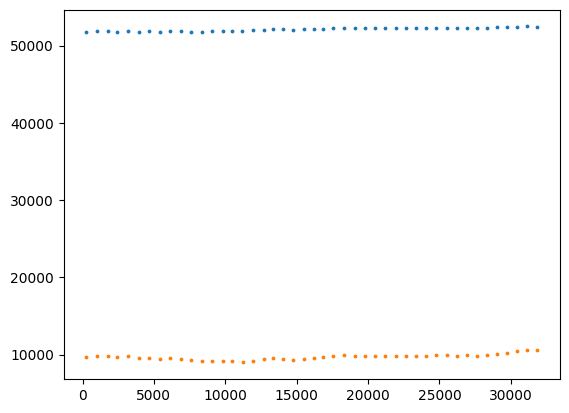

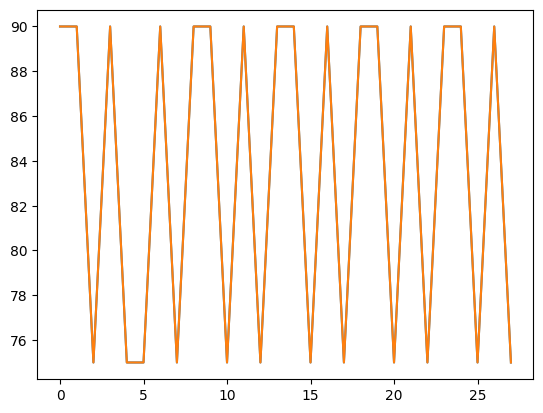

In [4]:
from scipy.signal import find_peaks

IR_peaks = find_peaks(IR, height = 50000, threshold = 0, distance = 6)
IR_peak_heights = IR_peaks[1]['peak_heights']
RED_peaks = find_peaks(RED, height = 6000, threshold = 1, distance = 10)
RED_peak_heights = RED_peaks[1]['peak_heights']
RED_peak_time, IR_peak_time = [], []

for x in IR_peaks[0] :
    IR_peak_time.append(time[x])
for x in RED_peaks[0] :
    RED_peak_time.append(time[x])

plt.figure(0)
plt.scatter(IR_peak_time, IR_peak_heights, s=3)
plt.scatter(RED_peak_time, RED_peak_heights, s=3)
plt.show()

IR_BPM, RED_BPM = [], []
for i in range(0, 28000, 1000) :
    IR_count, RED_count = 0, 0
    for x in IR_peak_time: 
        if(x>=i and x<i+4000) : IR_count+=1
    for y in RED_peak_time:
        if(y>=i and y<i+4000) : RED_count+=1
    IR_BPM.append(IR_count*15)
    RED_BPM.append(RED_count*15)

plt.figure(1)
plt.plot(np.arange(0,28), IR_BPM)
plt.plot(np.arange(0,28), RED_BPM)
plt.show()

##### Observations Task 2

Both IR anf RED reach peaks at the same time instant, they match. (few variations were visible)
BPM obtained from both readings were exactly similar.
BPM varied between 75 and 90.

<div class="alert alert-block alert-warning">
<b>Note:</b> For Tasks 3, 4 and 5 use only the RED channel data (no need to use IR data).
</div>

### Task 3: Frequency domain analysis [2 + 20 + 10 = 32 points] <a id='task3'></a>
1. What is the maximum frequency value that can be tracked in the provided signals?
2. Implement a function realizing the **coiling machine analogy** as discussed in class with detailed comments.
3. Run the coiling machine for `N = 32`, `64`, `128`, `256`, and `512` samples. Report the BPM values obtained in these five settings in a table. Validate the output with the library function `numpy.fft.fft`. Show the heatmaps as a 2x5 *subplot*. Label them properly. The top row corresponds to your function, while the bottom row corresponds to the numpy FFT implementation.

BPM for N=32 : 415.7142857142857
BPM for N=64 : 294.0
BPM for N=128 : 342.8225806451613
BPM for N=256 : 170.0595238095238
BPM for N=512 : 84.69980314960631


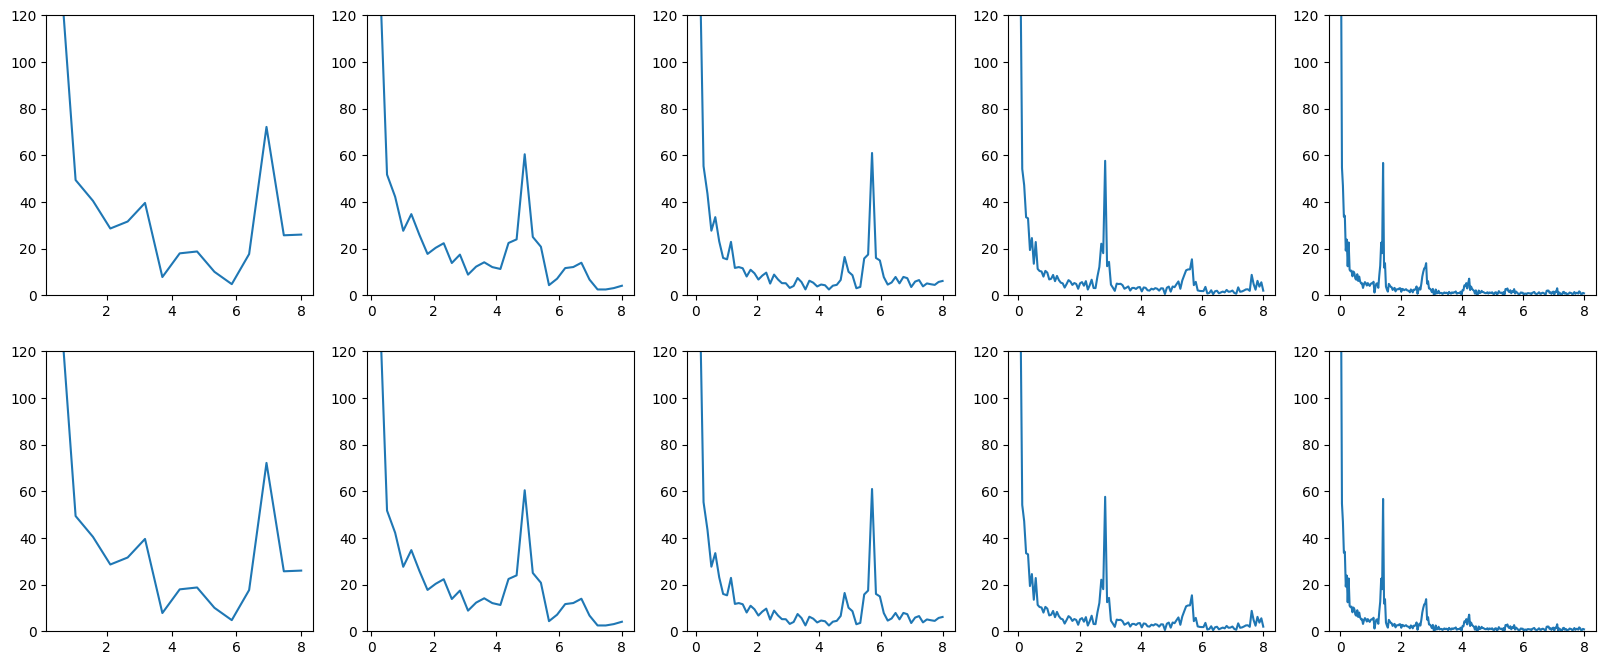

In [243]:
import math as m

def coiling_machine(signal, N) :
    W = [None]*N
    for F in range(int(-N/2), int(N/2)) :
        sum = 0
        for n in range(0,N) :
            sum += signal[int((512/N)*n)]*(complex(m.cos(2*m.pi*F*n/N), m.sin(2*m.pi*F*n/N)))
        W[F+int(N/2)] = abs(sum)/N
    return W

dtft_32 = coiling_machine(IR,32)[17:32]  
fft_32 = (1/32)*np.fft.fft(IR[:512:16])[1:16]
freq_32 = (1/2)*np.linspace(1,16,15)

dtft_64 = coiling_machine(IR,64)[33:64]
fft_64 = (1/64)*np.fft.fft(IR[:512:8])[1:32]
freq_64 = (1/4)*np.linspace(1,32,31)

dtft_128 = coiling_machine(IR,128)[65:128]
fft_128 = (1/128)*np.fft.fft(IR[:512:4])[1:64]
freq_128 = (1/8)*np.linspace(1,64,63)

dtft_256 = coiling_machine(IR,256)[129:256]
fft_256 = (1/256)*np.fft.fft(IR[:512:2])[1:128]
freq_256 = (1/16)*np.linspace(1,128,127)

dtft_512 = coiling_machine(IR,512)[257:512]
fft_512 = (1/512)*np.fft.fft(IR[:512:1])[1:256]
freq_512 = (1/32)*np.linspace(1,256,255)

peak_32 = find_peaks(dtft_32, height = 50, threshold = 0, distance = 1)
print("BPM for N=32 : " + str(60*freq_32[peak_32[0][0]]))
peak_64 = find_peaks(dtft_64, height = 50, threshold = 0, distance = 1)
print("BPM for N=64 : " + str(60*freq_64[peak_64[0][0]]))
peak_128 = find_peaks(dtft_128, height = 50, threshold = 0, distance = 1)
print("BPM for N=128 : " +str( 60*freq_128[peak_128[0][0]]))
peak_256 = find_peaks(dtft_256, height = 50, threshold = 0, distance = 1)
print("BPM for N=256 : " +str( 60*freq_256[peak_256[0][0]]))
peak_512 = find_peaks(dtft_512, height = 50, threshold = 0, distance = 1)
print("BPM for N=512 : " +str( 60*freq_512[peak_512[0][0]]))

pfig = plt.figure(figsize=(20,8))

plt.subplot(2, 5, 1)
plt.plot(freq_32, dtft_32)
plt.ylim(0,120)
plt.subplot(2, 5, 6)
plt.plot(freq_32, abs(fft_32))
plt.ylim(0,120)
plt.subplot(2, 5, 2)
plt.plot(freq_64, dtft_64)
plt.ylim(0,120)
plt.subplot(2, 5, 7)
plt.plot(freq_64, abs(fft_64))
plt.ylim(0,120)
plt.subplot(2, 5, 3)
plt.plot(freq_128, dtft_128)
plt.ylim(0,120)
plt.subplot(2, 5, 8)
plt.plot(freq_128, abs(fft_128))
plt.ylim(0,120)
plt.subplot(2, 5, 4)
plt.plot(freq_256, dtft_256)
plt.ylim(0,120)
plt.subplot(2, 5, 9)
plt.plot(freq_256, abs(fft_256))
plt.ylim(0,120)
plt.subplot(2, 5, 5)
plt.plot(freq_512, dtft_512)
plt.ylim(0,120)
plt.subplot(2, 5, 10)
plt.plot(freq_512, abs(fft_512))
plt.ylim(0,120)


plt.show()

##### Observations Task 3

Edit this section to put your observations.

| N         | BPM   |
| --------  | ------|
| 32        |  415  |
| 64        |  294  |
| 128       |  342  |
| 256       |  170  |
| 512       |  84   |

### Task 4: Spectrograms [10 + 10 = 20 points] <a id='task4'></a>
1. Plot the time-frequency spectrogram of the above data using your coiling machine function, taking a moving average window of size 2, 8, and 16 seconds. Show the heatmaps as a 1x3 *subplot*. Label them properly.
2. Add gaussian noise to the samples with a mean of 200 and a standard deviation of 50. Run the above analysis (4.1) again. Validate any improvement brought in by the 16 second window over the 2 or 8 second ones.

##### Observations Task 4

Edit this section to put your observations.

### Task 5: Quantization of sensor data [5 + 15 + 8 = 28 points] <a id='task5'></a>
Assume that a 16-bit ADC was used in the sensor that maps the range 0 to 5 volts.
1. How many bits would have sufficed at the minimum without losing the accuracy of the signal?
2. Now start lowering the number of bits (of course virtually), one at a time, up to a minimum of 2 bits, and represent the data with the relevant number of bits. Plot detected BPM versus the number of ADC bits. To detect BPM, directly use a 512-bin FFT on all the samples.
3. Does the plot in 5.2 change if we consider the noisy samples as produced in 4.2?

In [244]:
# --- your code here ---

##### Observations Task 5

Edit this section to put your observations.